In [2]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import gspread

In [3]:
tf.keras.backend.set_image_data_format("channels_last")

In [4]:
directory = "/workspace/tu-feb-2023--mina-ad-mina/src/Deep_Learning/Milestone 2/ABB.csv"
# First, we get the data

df = pd.read_csv(directory, index_col='Date', parse_dates=['Date'])
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-09-04,17.340000,17.370001,17.139999,17.240000,14.469431,1474300
2012-09-05,17.219999,17.389999,17.160000,17.320000,14.536574,3186600
2012-09-06,17.690001,17.959999,17.680000,17.910000,15.031758,3082300
2012-09-07,18.580000,18.700001,18.510000,18.650000,15.652837,3005200
2012-09-10,18.760000,18.770000,18.510000,18.540001,15.560513,1920300


In [68]:
training_set_size = int(len(df)*.8)
training_set = df.iloc[:training_set_size,3:4].values
test_set = df.iloc[training_set_size:,3:4].values
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [69]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements 
X_train = []
y_train = []
for i in range(60,len(training_set_scaled)):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [70]:
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [71]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
30/30 [==============================] - 11s 126ms/step - loss: 0.0393
Epoch 2/50
30/30 [==============================] - 4s 126ms/step - loss: 0.0193
Epoch 3/50
30/30 [==============================] - 4s 127ms/step - loss: 0.0174
Epoch 4/50
30/30 [==============================] - 4s 124ms/step - loss: 0.0141
Epoch 5/50
30/30 [==============================] - 4s 126ms/step - loss: 0.0128
Epoch 6/50
30/30 [==============================] - 4s 127ms/step - loss: 0.0116
Epoch 7/50
30/30 [==============================] - 4s 128ms/step - loss: 0.0122
Epoch 8/50
30/30 [==============================] - 4s 126ms/step - loss: 0.0097
Epoch 9/50
30/30 [==============================] - 4s 128ms/step - loss: 0.0100
Epoch 10/50
30/30 [==============================] - 4s 133ms/step - loss: 0.0090
Epoch 11/50
30/30 [==============================] - 4s 129ms/step - loss: 0.0085
Epoch 12/50
30/30 [==============================] - 4s 128ms/step - loss: 0.0094
Epoch 13/50
30/30 [=====

In [72]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole 
# 'High' attribute data for processing
dataset_total = pd.concat((df.iloc[:training_set_size]["Close"],df.iloc[training_set_size:]["High"]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [73]:
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

8/8 [==============================] - 2s 32ms/step


In [74]:
# Some functions to help out with
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real AAPL Stock Price')
    plt.plot(predicted, color='blue',label='Predicted AAPL Stock Price')
    plt.title('AAPL Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('AAPL Stock Price')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

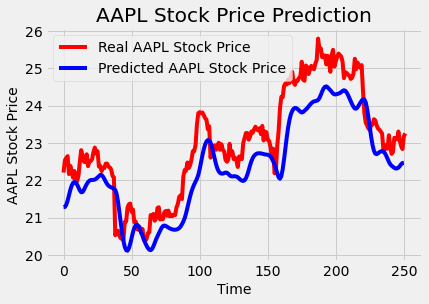

In [80]:
# Visualizing the results for LSTM

plot_predictions(test_set,predicted_stock_price)

In [82]:
test_set = test_set[:251]
predicted_stock_price = predicted_stock_price[:251]

In [83]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Generate some sample data
y_true = np.array([1, 2, 3, 4, 5])
y_pred = np.array([1.5, 2.5, 3.5, 4.5, 5.5])

# Calculate MSE
mse = mean_squared_error(test_set, predicted_stock_price)

# Calculate RMSE
rmse = np.sqrt(mse)

# Calculate MAE
mae = mean_absolute_error(test_set, predicted_stock_price)

# Calculate MAPE
mape = np.mean(np.abs((test_set - predicted_stock_price) / test_set)) * 100

# Print the results
print('MSE:', mse)
print('RMSE:', rmse)
print('MAE:', mae)
print('MAPE:', mape)


MSE: 0.6305444790159661
RMSE: 0.7940683087845567
MAE: 0.691974913423941
MAPE: 2.9700349306641227
